# Multiclass Brain Tumor Detection Using Convolutional Neural Network
## Project Introduction
- This project focuses on multiclass classification for brain tumor detection using Convolutional Neural Network (CNN).
- A custom CNN model is built from scratch with PyTorch without using conventional pre-trained models, such as ResNet and VGG.<br>

### Primary Objectives
  1. Apply appropriate spatial and intensity augmentations to improve generalization.
  2. Design, train, and optimize CNN architecture tailored to the dataset.
  3. Achieve high test accuracy while maintaining model efficiency and robustness.
  4. Evaluate the final test results and identify limitations and potential improvements for future work.

### Files
- `constants.py`: contains path to data and train result and all hyperparameters for dataloader, transformation, and model construction.
- `dataset.py`: defines a custom Dataset class that inherits from `torch.utils.data.Dataset`.
- `train.py`: contains a training function for the model.
- `helpers.py`: contains all helper functions to support visualizations, saving/loading data, and other tasks from this note.

<br><br>

## Import & Setup

In [1]:
import os
import copy

# ds tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# torch
import torchvision.transforms.v2 as v2
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision.io import decode_image

# custom files
from dataset import *
from constants import *
from helpers import *
from train import *

<br><br>

## Data Preview



--------------------------------------- Randomly selected samples from glioma ---------------------------------------


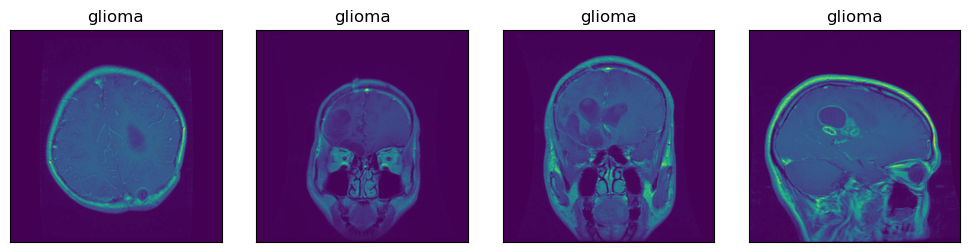



--------------------------------------- Randomly selected samples from meningioma ---------------------------------------


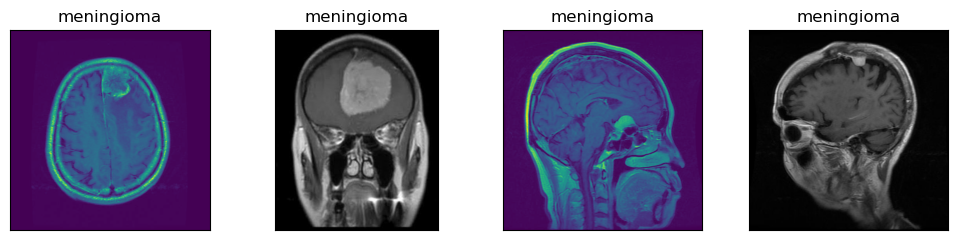



--------------------------------------- Randomly selected samples from pituitary ---------------------------------------


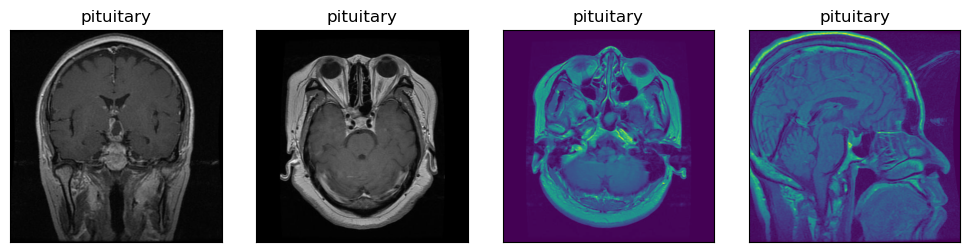



--------------------------------------- Randomly selected samples from non_tumorous ---------------------------------------


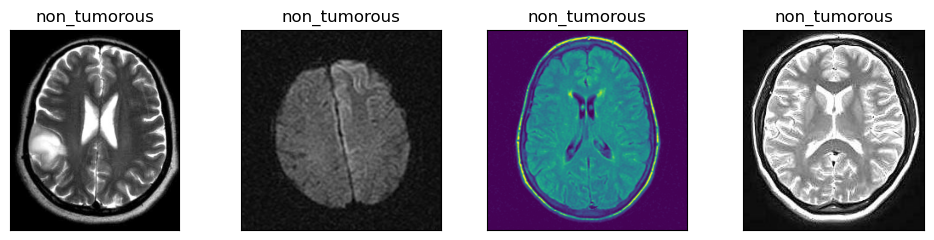

In [2]:
# retrieve images from each data folder
train_imgs = list(Path(TRAIN_DATA_DIR).glob('**/*.jpg')) 
test_imgs = list(Path(TEST_DATA_DIR).glob('**/*.jpg')) 

train_img_paths = [str(img) for img in train_imgs 
                   if '.ipynb_checkpoints' not in str(img) and 'Copy' not in str(img)] # to not contain checkpoint files in img path list

test_img_paths = [str(img) for img in test_imgs 
                   if '.ipynb_checkpoints' not in str(img) and 'Copy' not in str(img)] 


# define a label for each image in both train and test set
train_labels = [os.path.split(os.path.split(name)[0])[1] for name in train_img_paths]
test_labels = [os.path.split(os.path.split(name)[0])[1] for name in test_img_paths]

# print randomly selected samples from each class
print_class_samples('glioma', train_img_paths, 1)
print_class_samples('meningioma', train_img_paths, 1)
print_class_samples('pituitary', train_img_paths, 1)
print_class_samples('non_tumorous', train_img_paths, 1)

<br><br>

## Data Splitting

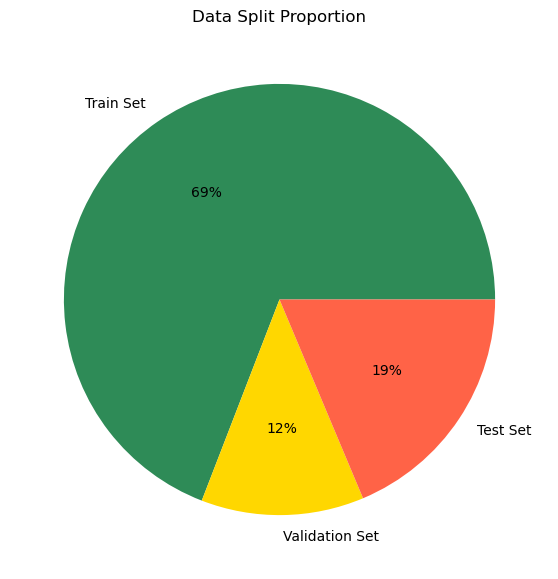

Train set length: 4855 | Validation set length: 857 | Test set length: 1311 



In [3]:
# find length of the whole dataset
data_size = len(train_img_paths) + len(test_img_paths)

# split train data into train and validation set
test_set, test_set_labels = test_img_paths, test_labels
train_data, train_data_labels = train_img_paths, train_labels
train_set, valid_set, train_set_labels, valid_set_labels = train_test_split(train_img_paths, train_labels, test_size = 0.15, shuffle = True, random_state = 13)

# get size of each set
train_set_size = len(train_set)/data_size
valid_set_size = len(valid_set)/data_size
test_set_size = len(test_set)/data_size

# draw a pie chart showing data split prop
plt.figure(figsize=(7, 7))
pie_colors = ['seagreen', 'gold', 'tomato']
plt.pie([train_set_size, valid_set_size, test_set_size], labels = ['Train Set', 'Validation Set', 'Test Set'], colors = pie_colors, autopct='%1.0f%%')
plt.title('Data Split Proportion')
plt.show()

print(f"Train set length: {len(train_set)} | Validation set length: {len(valid_set)} | Test set length: {len(test_set)} \n")

<br>



-------------------------------------------------- Samples from train set --------------------------------------------------


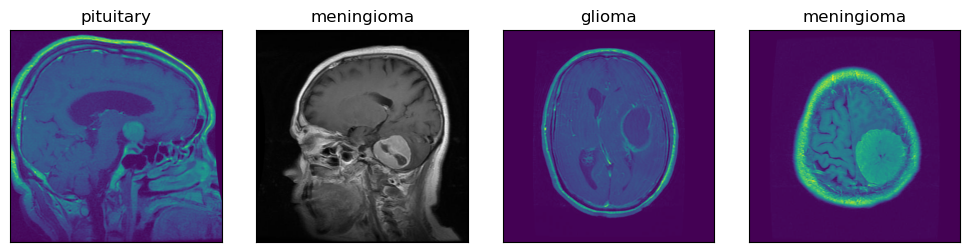



-------------------------------------------------- Samples from validation set --------------------------------------------------


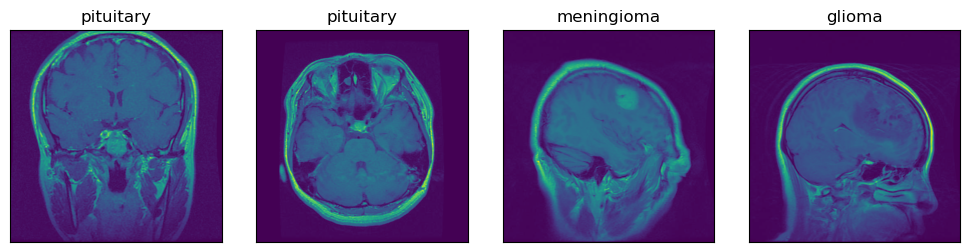



-------------------------------------------------- Samples from test set --------------------------------------------------


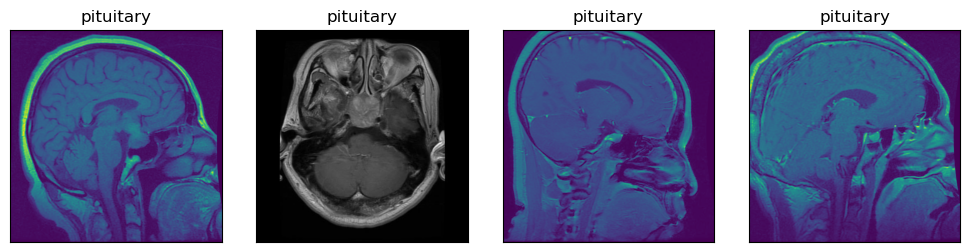

In [4]:
# print train set, validation set, and test set samples
print_samples('train set', train_set, train_set_labels, 1)
print_samples('validation set', valid_set, valid_set_labels, 1)
print_samples('test set', test_set, test_set_labels, 1)

<br><br>

## Exploratory Data Analysis

### Check Missing Labels

In [5]:
num_total_labels = len(train_labels) + len(test_labels)

print(f"Dataset size: {data_size} | Number of labels: {num_total_labels} | Number of missing labels: {data_size - num_total_labels}")

Dataset size: 7023 | Number of labels: 7023 | Number of missing labels: 0


- The dataset consists of 7023 MRI images, which can be considered a moderately sized dataset for this task.
- As specified above, the number of labels aligns with the dataset size, which ensures that all images are assigned with a corresponding label.

<br>

### Class Types

In [6]:
# get unique classes from labels
classes = list(set(train_labels))
print(f"Number of classes: {len(classes)} | Name of classes: {classes}")

# manually edit the order of classes for a better readability
classes = ['non_tumorous', 'glioma', 'meningioma', 'pituitary']

Number of classes: 4 | Name of classes: ['non_tumorous', 'pituitary', 'glioma', 'meningioma']


- The dataset contains four distinct classes: three tumor types (meningioma, glioma, and pituitary) and one non-tumorous category.
- Hence, the classification task here is framed as a multi-class problem, where the model must:
   1. distinguish between malignant (cancerous) and benign (non-cancerous) cases
   2. further identify the specific tumor type if a tumor is present

<br>

### Image Dimensions

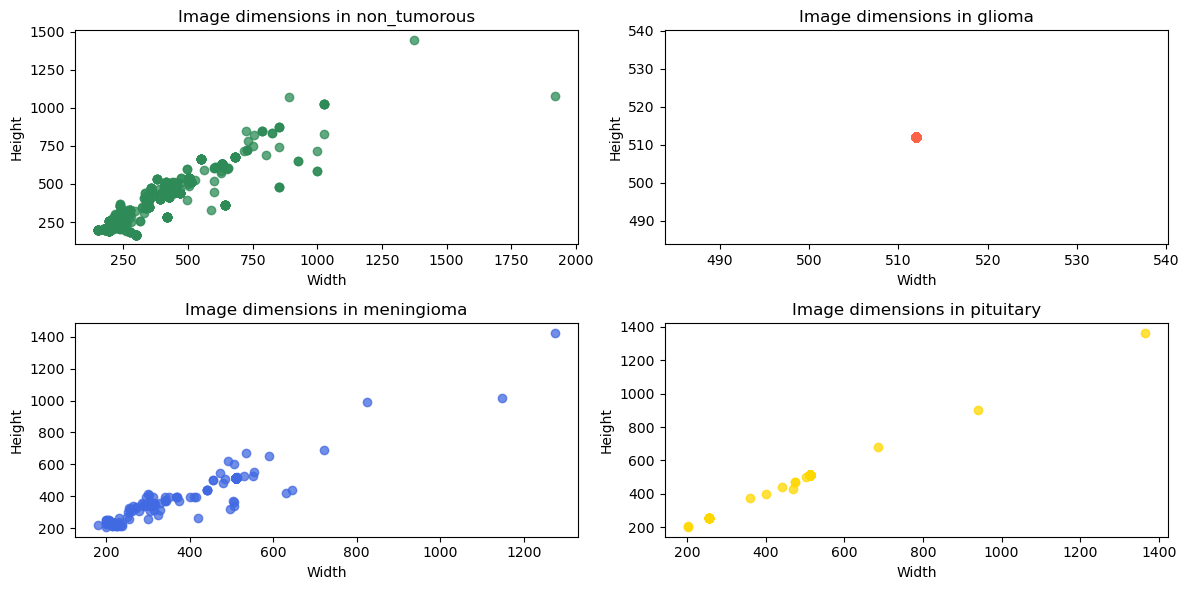


Number of unique image dimensions in non_tumorous: 229
Sample image dimensions in non_tumorous: [(472, 537) (393, 400) (420, 280) (225, 225) (150, 198)]

Number of unique image dimensions in glioma: 1
Unique image dimensions in class glioma: [(512, 512)]

Number of unique image dimensions in meningioma: 110
Sample image dimensions in meningioma: [(512, 512) (330, 355) (300, 258) (491, 624) (306, 306)]

Number of unique image dimensions in pituitary: 13
Sample image dimensions in pituitary: [(512, 512) (256, 256) (940, 900) (470, 432) (474, 474)]


In [7]:
# create a df to contain dimensions of train set samples
height_dict = {}
width_dict = {}
dim_dict = {}

for i, img_path in enumerate(train_set):
    dim = Image.open(train_set[i]).size

    # store dim tuple and separate height and width
    dim_dict[i] = dim
    width_dict[i] = dim[0]
    height_dict[i] = dim[1]

img_dimensions = pd.DataFrame({'class': train_set_labels})
img_dimensions['width'] = width_dict
img_dimensions['height'] = height_dict
img_dimensions['dim'] = dim_dict

# draw a scatter plot for each class in train set
fig, axes = plt.subplots(2,2, figsize = (12,6))
axes = axes.flatten()
colors = ['seagreen', 'tomato', 'royalblue', 'gold']

for i, label in enumerate(classes):
    label_df = img_dimensions[img_dimensions['class'] == label]
    
    axes[i].scatter(label_df['width'], label_df['height'], color = colors[i], alpha = 0.75)
    axes[i].set_xlabel('Width')
    axes[i].set_ylabel('Height')
    axes[i].set_title(f'Image dimensions in {label}')

plt.tight_layout()
plt.show()

# print unique dimensions in each class
for label in classes:
    label_df = img_dimensions[img_dimensions['class'] == label]
    label_unique_dims = label_df['dim'].unique()
    print(f'\nNumber of unique image dimensions in {label}: {len(label_unique_dims)}')

    if len(label_unique_dims) == 1: print(f'Unique image dimensions in class {label}: {label_unique_dims}')
    else: print(f'Sample image dimensions in {label}: {label_unique_dims[:5]}')


- As described above, only the glioma images share a uniform dimension of (512, 512), while the other three classes vary in size.
- Therefore, resizing must be done during data transformation to ensure consistent input size.

<br>

### Check Class Imbalance

Size of non_tumorous: 1343
Size of glioma: 1133
Size of meningioma: 1139
Size of pituitary: 1240




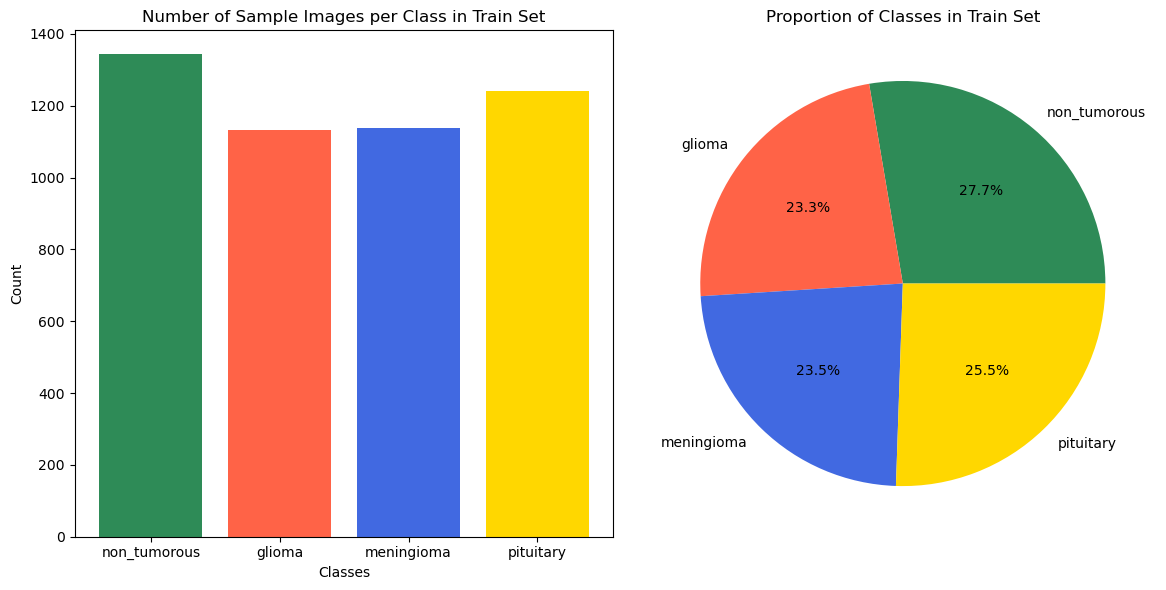

In [8]:
# create a dictionary to track the size of each class
class_df = pd.DataFrame()
class_df['class'] = classes
class_df['size'] = None

# find size for each class in train set
for class_name in classes:
    class_img_paths = [path for path in train_set if class_name in path]
    class_size = len(class_img_paths)
    class_df.loc[class_df['class'] == class_name, 'size'] = class_size
    print(f"Size of {class_name}: {class_size}")
print("\n")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# draw a bar plot with color fill
ax1.bar(class_df['class'], class_df['size'], color = colors)
ax1.set_xlabel("Classes")
ax1.set_ylabel("Count")
ax1.set_title("Number of Sample Images per Class in Train Set")

# draw a pie chart with color fill
ax2.pie(class_df['size'], labels = class_df['class'], colors = colors, autopct='%1.1f%%')
ax2.set_title("Proportion of Classes in Train Set")

plt.tight_layout()
plt.show()

- Ranking by the number of samples, from most to least: `non_tumorous` > `pituitary` > `glioma` > `meningioma`
- While the `non_tumorous` has roughly 150–230 more samples than the other classes, this difference represents only a minor class imbalance with an assumption that class imabalance is negligible unless one class is a multiple of the others.
- Hence, the imbalance here is considered insignificant and is unlikely to adversely affect model training.

<br><br>

## Data Preprocessing
### Ordinal Encoding

In [9]:
ordinal_encoding_mapping = {
    'non_tumorous': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

encoding_df = pd.DataFrame({'class': ordinal_encoding_mapping.keys(),
                            'encoding': ordinal_encoding_mapping.values()})
encoding_df.set_index('class', inplace = True)
encoding_df

encoding
class                 
non_tumorous         0
glioma               1
meningioma           2
pituitary            3

- Since `nn.EntropyLoss` expects integer class labels, ordinal encoding is applied instead of one-hot encoding (OHE).

<br>

In [10]:
train_set_labels = [ordinal_encoding_mapping[label] for label in train_set_labels]
valid_set_labels = [ordinal_encoding_mapping[label] for label in valid_set_labels]
test_set_labels = [ordinal_encoding_mapping[label] for label in test_set_labels]

# print sample labels to ensure it is encoded correctly
np.random.seed(13)
random_indices = np.random.randint(0, len(valid_set), 3)

print('----------------------------Check if encoding was done correctly----------------------------\n')
for i in random_indices:
    print(f"train set image {i}: {train_set[i]} | encoded label: {train_set_labels[i]}")
    print(f"validation set image {i}: {valid_set[i]} | encoded label: {valid_set_labels[i]}")
    print(f"train set image {i}: {test_set[i]} | encoded label: {test_set_labels[i]}\n")

----------------------------Check if encoding was done correctly----------------------------

train set image 338: ../data/training/pituitary/pituitary_706.jpg | encoded label: 3
validation set image 338: ../data/training/non_tumorous/non_tumorous_1321.jpg | encoded label: 0
train set image 338: ../data/testing/glioma/glioma_120.jpg | encoded label: 1

train set image 176: ../data/training/glioma/glioma_1005.jpg | encoded label: 1
validation set image 176: ../data/training/meningioma/meningioma_1205.jpg | encoded label: 2
train set image 176: ../data/testing/pituitary/pituitary_40.jpg | encoded label: 3

train set image 74: ../data/training/meningioma/meningioma_705.jpg | encoded label: 2
validation set image 74: ../data/training/pituitary/pituitary_179.jpg | encoded label: 3
train set image 74: ../data/testing/pituitary/pituitary_39.jpg | encoded label: 3



<br>

### Image Transformation & Augmentation

In [11]:
# set seed
torch.manual_seed(13)

# define transform pipeline for train set and test set
train_transformer = v2.Compose([
    # resizing
    v2.Resize(IMG_RESIZE_DIM, antialias = True),

    # spatial augmentation
    v2.RandomRotation(20),
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop(size=IMG_RESIZE_DIM, scale = (0.8, 1.0)),
    v2.RandomAffine(degrees=0, translate=(0.05, 0.05)),

    # intensity augmentation
    v2.RandomAdjustSharpness(sharpness_factor=2),
    v2.RandomChoice([
        v2.RandomAutocontrast(),
        v2.RandomEqualize(),
    ]),

    # convert to tensor and normalize
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformer = v2.Compose([
    # resizing
    v2.Resize(IMG_RESIZE_DIM, antialias = True),

    # convert to tensor and normalize
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Train Data Transformation
- Resizing image to (224, 224) to ensure consistent input dimensions for the CNN as mentioned earlier.
  - (224, 224) is used instead of (512, 512) for training efficiency.
- Spatial augmentations to introduce variations in image orientation, position, and scale.
- Intensity augmentations to randomly enhance visual features, such as contrast and sharpness, to help model learn robust representations despite variations in MRI scans.
    - `RandomChoice` is used to randomly apply either `RandomAutoContrast` or `RandomEqualize`, preventing the image contrast from being modified twice in the same transformation.
- Tensor Transformation
  - `ToImage` + `ToDType` was used instead of `ToTensor` (deprecated in `torchvision.transforms.v2`).
- Normalization<br><br>
#### Validation & Test Data Transformation
- Resizing image to (224, 224)
- Tensor Transformation
- Normalization

<br>

### Visual Inspection of Augmented Images

#### Randomly Selected Transformed Train Set Samples

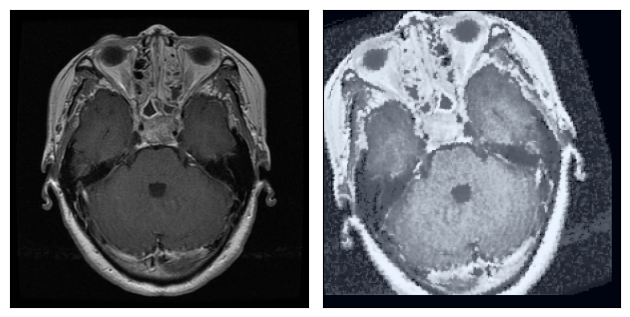

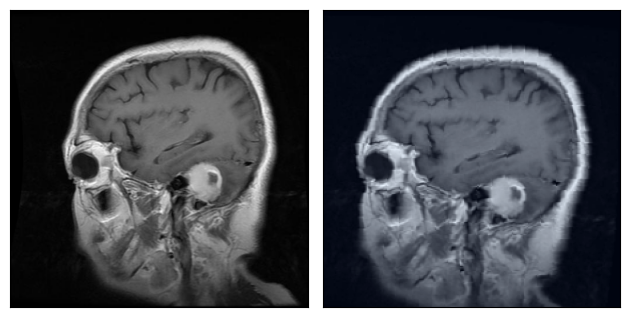

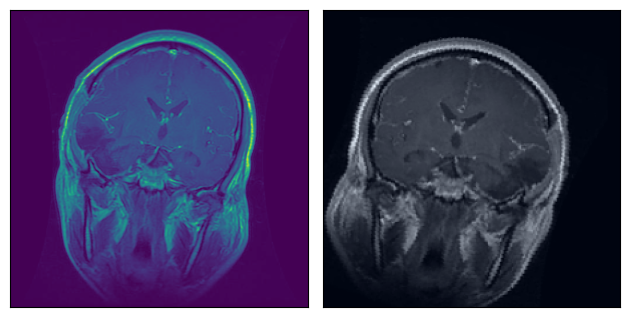

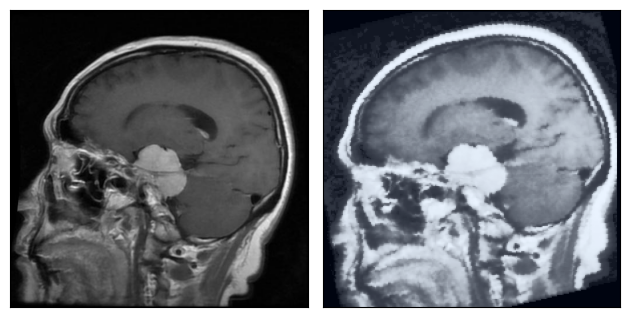

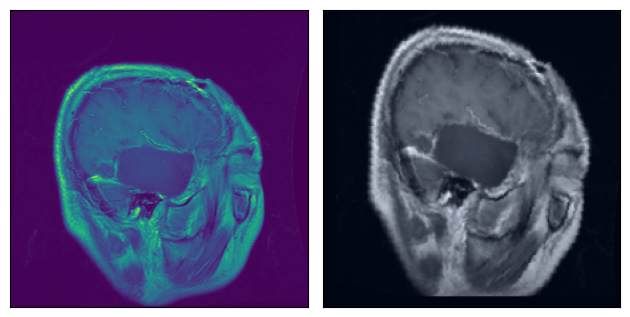

In [12]:
np.random.seed(13)
for idx in np.random.randint(0, len(train_set), 5):
    img = Image.open(train_set[idx])
    out = train_transformer(img)
    plot([img, out])

<br>

#### Randomly Selected Transformed Test Set Images

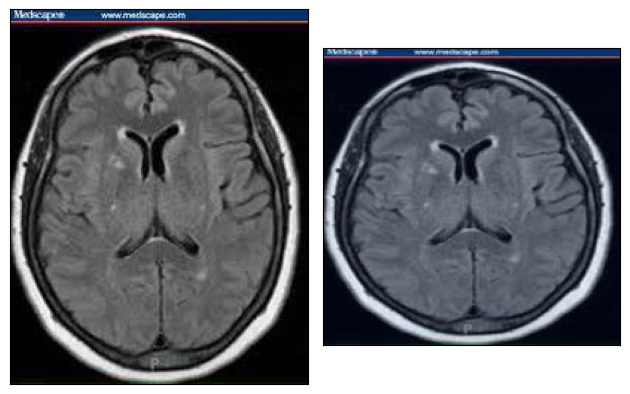

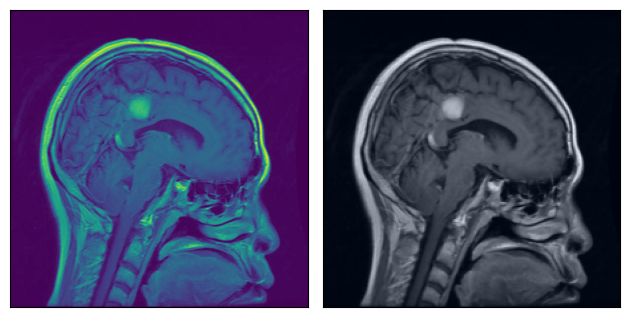

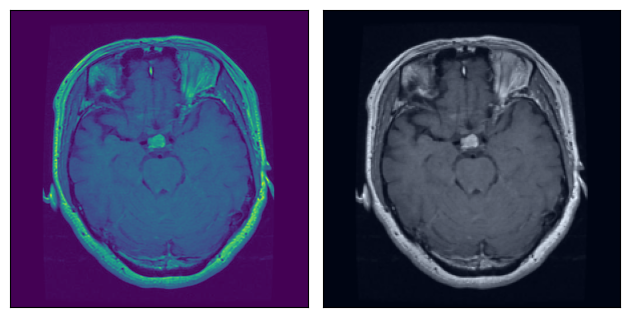

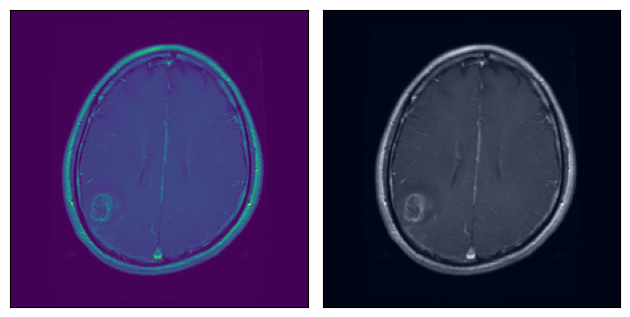

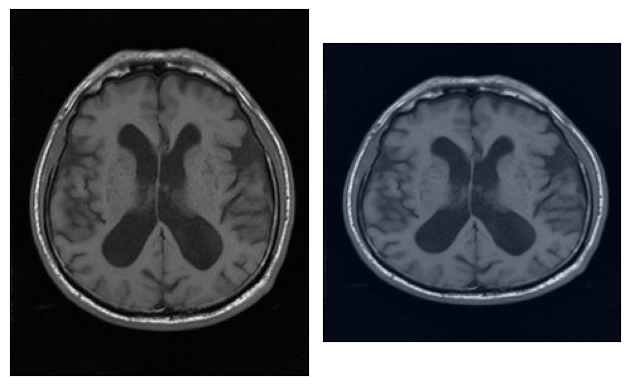

In [13]:
np.random.seed(16)
for idx in np.random.randint(0, len(test_set), 5):
    img = Image.open(test_set[idx])
    out = test_transformer(img)
    plot([img, out])

<br>

### Input Image Dimension after Transformation

In [14]:
img = Image.open(test_set[1])
transformed_img = test_transformer(img)

print(f'Image dimension: {transformed_img.size()}')

Image dimension: torch.Size([3, 224, 224])


<br>

### Load Data

In [15]:
# define Dataset objects (Dataset class is defined in dataset.py)
Dataset_train = Dataset(train_set, train_set_labels, transform = train_transformer)
Dataset_valid = Dataset(valid_set, valid_set_labels, transform = test_transformer)
Dataset_test = Dataset(test_set, test_set_labels, transform = test_transformer)

# define DataLoader for each Dataset
train_loader = DataLoader(Dataset_train, 
                          batch_size = BATCH_SIZE,
                          num_workers = NUM_WORKERS,
                          persistent_workers = True,   
                          prefetch_factor = PREFETCH_FACTOR,
                          drop_last = True, 
                          shuffle = True)

valid_loader = DataLoader(Dataset_valid, 
                          batch_size = BATCH_SIZE,
                          num_workers = NUM_WORKERS,
                          persistent_workers = True,   
                          prefetch_factor = PREFETCH_FACTOR,
                          drop_last = False, 
                          shuffle = False)

test_loader = DataLoader(Dataset_test, 
                         batch_size = BATCH_SIZE,
                         num_workers = NUM_WORKERS,
                         persistent_workers = True,   
                         prefetch_factor = PREFETCH_FACTOR,
                         drop_last = False, 
                         shuffle = False)

- Since Apple MPS doesn't support `pin_memory = True` unlike Nvidia CUDA, `persistent_workers = True` + `prefetch_factor` is used to accelerate the data loading and improve training efficiency.

<br>

## Model Construction & Optimization
### Model Design & Optimzation Strategy
1. Design a baseline CNN model and evaluate the validation and test result.
2. Experiment different architectural variations based on the baseline model and identify which components improve generelization and contribute to higher validation and test accuracy in comparison with the baseline model's performance.
3. Construct the final CNN model based on the insights gained from step 2
4. Compare the performance of all model variants and select the best-performing model.

### Training Strategy
- Training function supports early stopping such that we the best performing model across epochs can be saved right before it overfits.

<br>

### Custom Model 1: Baseline CNN
- The general structure of pre-trained CNN models, which have already proven its strong performance, can be summarized as: $N$ x Convolutional Blocks + Flatten + Fully Connected Layers with extra architectural elements
- Therefore, for the baseline model in this project, I start with four convolutional blocks (each consisting of `Conv` → `BatchNorm` → `ReLU` → `MaxPool`) followed by two fully connected layers with a dropout layer for regularization.

In [16]:
class CustomCNN_1(nn.Module):
    def __init__(self, fc_layer_size, dropout_rate, num_classes):
        super(CustomCNN_1, self).__init__()

        # v2.F doesn't work so define activation and pool as global
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)

        # first convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # fourth convolutional block
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # fully connected layers + dropout
        self.fc1 = nn.Linear(256 * 14 * 14, fc_layer_size)
        self.dropout = nn.Dropout(dropout_rate)  
        self.fc2 = nn.Linear(fc_layer_size, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x)))) # 224 -> 112
        x = self.pool(self.relu(self.bn2(self.conv2(x)))) # 112 -> 56
        x = self.pool(self.relu(self.bn3(self.conv3(x)))) # 56 -> 28
        x = self.pool(self.relu(self.bn4(self.conv4(x)))) # 28 -> 14

        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [17]:
# define custom_cnn_1 obj
custom_cnn_1 = CustomCNN_1(FC_LAYER_SIZE, DROPOUT_RATE, NUM_CLASSES)

# define path to save custom_cnn_1
path_to_custom_cnn_1 = f'{DIR_TO_SAVE_MODEL}/custom_cnn_1.pth'

# define path to save train result 
path_to_train_result_1 = f'{DIR_TO_TRAIN_RESULT}/train_result_custom_cnn_1.csv'

# define path to save best epoch
epoch_filename_1 = 'best_epoch_custom_cnn_1.csv'

# if haven't trained, train custom_cnn_1 model
if not os.path.exists(path_to_custom_cnn_1):
    # train model, save it to the given path, and return train result data
    result_df, epoch_custom_cnn_1 = train(custom_cnn_1, train_loader, valid_loader, DEVICE, LEARNING_RATE, EPOCHS, PATIENCE, path_to_custom_cnn_1)

    # save train result to the given path
    result_df.to_csv(path_to_train_result_1)

    # save best epoch 
    save_epoch_to_csv(epoch_custom_cnn_1, epoch_filename_1)

# get df that contains all train, valid, test acc and loss
model_1_eval_df = get_eval_df('custom_cnn_1', custom_cnn_1, epoch_filename_1, path_to_train_result_1, test_loader, path_to_custom_cnn_1, DEVICE)

# print df
model_1_eval_df

train_acc  train_loss  valid_acc  valid_loss   test_acc  \
model                                                                   
custom_cnn_1  94.143212    0.178395   97.89965    0.094146  97.559115   

              test_loss  
model                    
custom_cnn_1   0.077345

<br>

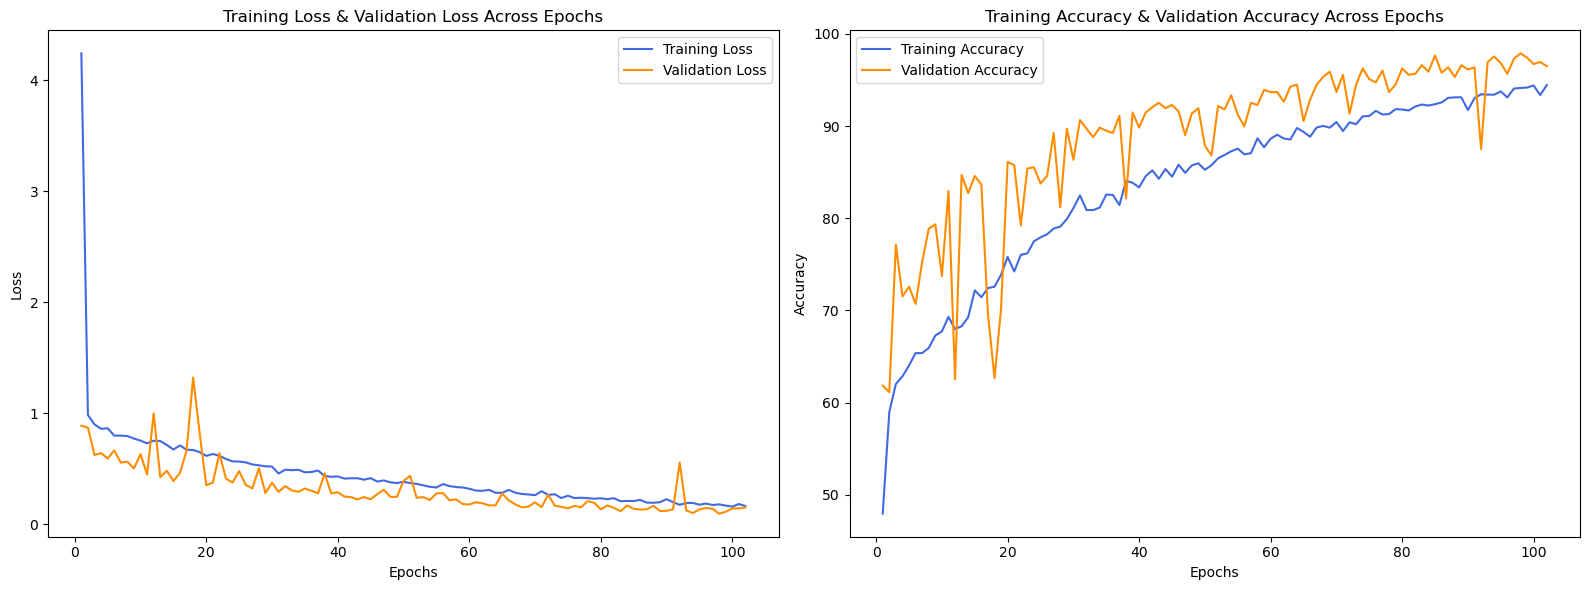

In [18]:
plot_train_valid_result(path_to_train_result_1)

#### Baseline Model Evaluation
- Note that the model contains a dropout layer, which is only active during training. Hence, it is expected to have a slighlty lower train score compared to the validation score.
- With a validation accuracy of 97.9% and a test accuracy of 97.6%, the baseline model demonstrates great performance.
- However, while it is common to see high fluctuaitons during the early stages of training and the validation curve does stabilize later, the overall pattern remains somewhat wavy, indicating a moderate degree of instability during the validation.
  - Note that I refer to the validation curve as encompassing both validation accuracy and validation loss curves.
- While such curve doesn't necessarily imply a bad generalization and the baseline model already has very high validation and test scores, there exists a room for improvement in architectural structure to achieve stronger performance on both validation and test data.
- Therefore, I will explore different architectural variations to improve the model's regularization.

<br>

### Custom Model 2: Model 1 + Additional Dropout Layer per Block

In [19]:
class CustomCNN_2(nn.Module):
    def __init__(self, fc_layer_size, dropout_rate, num_classes):
        super(CustomCNN_2, self).__init__()
        # define pool and activation func
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        
        # first convolutional block
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)
        
        # second convolutional block
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)
        
        # third convolutional block
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.25)

        # fourth convolutional block
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.25)
        
        # fully connected layers
        self.fc1 = nn.Linear(50176, fc_layer_size)  
        self.dropout5 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_layer_size, num_classes)
        
    def forward(self, x):
        # first conv -> batch norm -> pool (224 -> 112) -> dropout (0.25)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        # second conv -> batch norm -> pool (112 -> 56) -> dropout (0.25)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        # third conv -> batch norm -> pool (56 -> 28) -> dropout (0.25)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        # fourth conv -> batch norm -> pool (28 -> 14) -> dropout (0.25)
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        # flatten output 
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout5(x)
        x = self.fc2(x)
        
        return x

In [20]:
# define custom_cnn_2 obj
custom_cnn_2 = CustomCNN_2(FC_LAYER_SIZE, DROPOUT_RATE, NUM_CLASSES)

# define path to save custom_cnn_2
path_to_custom_cnn_2 = f'{DIR_TO_SAVE_MODEL}/custom_cnn_2.pth'

# define path to save train result 
path_to_train_result_2 = f'{DIR_TO_TRAIN_RESULT}/train_result_custom_cnn_2.csv'

# define path to save best epoch
epoch_filename_2 = 'best_epoch_custom_cnn_2.csv'

# if haven't trained, train custom_cnn_2 model
if not os.path.exists(path_to_custom_cnn_2):
    # train model, save it to the given path, and return train result data
    result_df, epoch_custom_cnn_2 = train(custom_cnn_2, train_loader, valid_loader, DEVICE, LEARNING_RATE, EPOCHS, PATIENCE, path_to_custom_cnn_2)

    # save train result to the given path
    result_df.to_csv(path_to_train_result_2)

    # save best epoch 
    save_epoch_to_csv(epoch_custom_cnn_2, epoch_filename_2)

# get df that contains all train, valid, test acc and loss
model_2_eval_df = get_eval_df('custom_cnn_2', custom_cnn_2, epoch_filename_2, path_to_train_result_2, test_loader, path_to_custom_cnn_2, DEVICE)

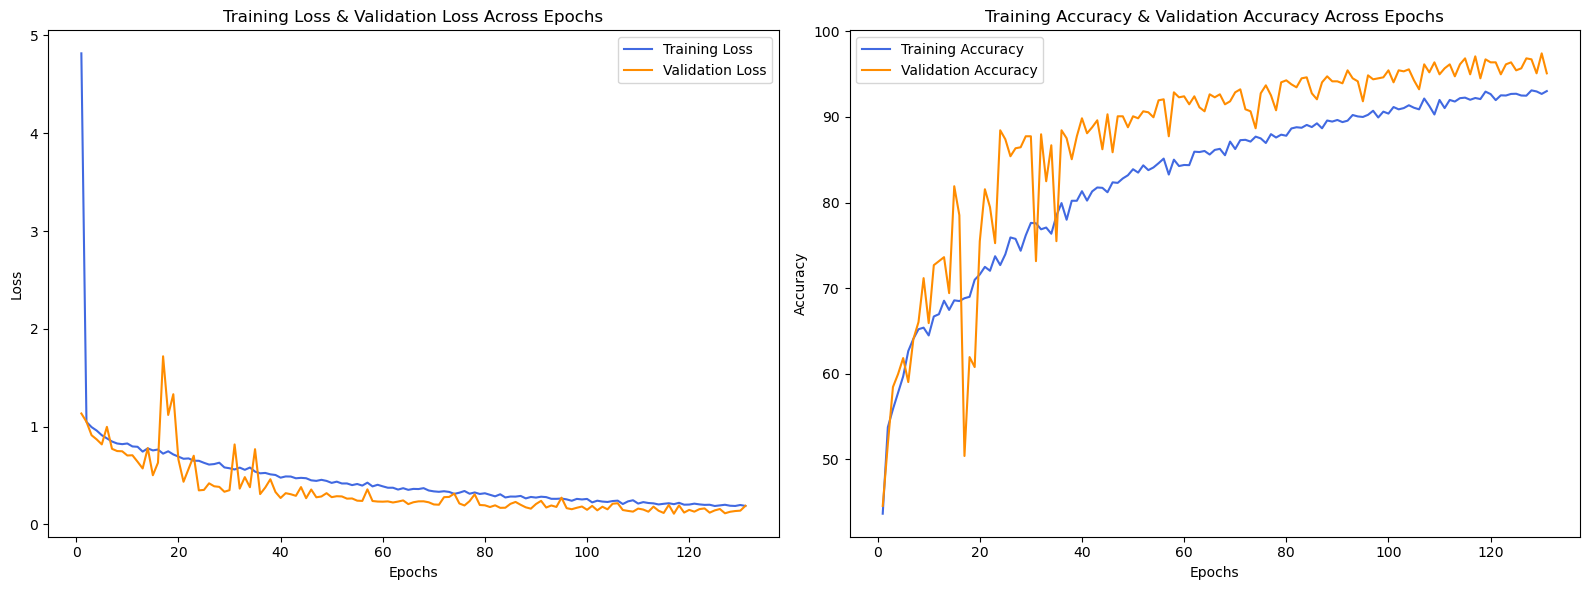

In [21]:
plot_train_valid_result(path_to_train_result_2)

In [22]:
model_2_eval_df

train_acc  train_loss  valid_acc  valid_loss   test_acc  \
model                                                                   
custom_cnn_2  92.487583    0.201564  96.849475    0.114395  95.804729   

              test_loss  
model                    
custom_cnn_2   0.102302

#### Model 2 Evaluation
- Model 2 is constructed with the same strcuture as the baseline model, but includes an additional dropout layer with a 25% dropout rate per block. It is to experiment whether adding additional dropout layers, which is a common regularization approach, can help improving validaiton and test accuracy while producing a smoother validation curve.
- While the early stages of training show greater fluctuations than the baseline model, model 2 demonstrates much more stable convergence after epoch 40, indicating good generalization.
- However, model 2 has slightly lower scores in both validation and test results, likely because neurons are dropped too frequently during training due to the multiple dropout layers.
- Hence, it raises a need to further investigation on whether including less dropout layers would increase validation and test scores while keeping good performance in generalization.

<br>

### Custom Model 3: Model 1 + Additional Convolutional Layer per Block

In [23]:
class CustomCNN_3(nn.Module):
    def __init__(self, fc_layer_size, dropout_rate, num_classes):
        super(CustomCNN_3, self).__init__()

        # v2.F doesn't work so define activation and pool as global
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)

        # first convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # third convolutional block
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # fourth convolutional block
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # fully connected layers + dropout
        self.fc1 = nn.Linear(256 * 14 * 14, fc_layer_size)
        self.dropout = nn.Dropout(dropout_rate)  
        self.fc2 = nn.Linear(fc_layer_size, num_classes)

    def forward(self, x):
        # first conv -> batch norm -> second conv -> batch norm -> pool (224 -> 112)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn1(self.conv2(x)))
        x = self.pool(x)

        # third conv -> batch norm -> fourth conv -> batch norm -> pool (112 -> 56)
        x = self.relu(self.bn2(self.conv3(x)))
        x = self.relu(self.bn2(self.conv4(x)))
        x = self.pool(x)

        # fifth conv -> batch norm -> sixth conv -> batch norm -> pool (56 -> 28)
        x = self.relu(self.bn3(self.conv5(x)))
        x = self.relu(self.bn3(self.conv6(x)))
        x = self.pool(x)

        # seventh conv -> batch norm -> eighth conv -> batch norm -> pool (28 -> 14)
        x = self.relu(self.bn4(self.conv7(x)))
        x = self.relu(self.bn4(self.conv8(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
# define custom_cnn_3 obj
custom_cnn_3 = CustomCNN_3(FC_LAYER_SIZE, DROPOUT_RATE, NUM_CLASSES)

# define path to save custom_cnn_3
path_to_custom_cnn_3 = f'{DIR_TO_SAVE_MODEL}/custom_cnn_3.pth'

# define path to save train result 
path_to_train_result_3 = f'{DIR_TO_TRAIN_RESULT}/train_result_custom_cnn_3.csv'

# define path to save best epoch
epoch_filename_3 = 'best_epoch_custom_cnn_3.csv'

# if haven't trained, train custom_cnn_3 model
if not os.path.exists(path_to_custom_cnn_3):
    # train model, save it to the given path, and return train result data
    result_df, epoch_custom_cnn_3 = train(custom_cnn_3, train_loader, valid_loader, DEVICE, LEARNING_RATE, EPOCHS, PATIENCE, path_to_custom_cnn_3)

    # save train result to the given path
    result_df.to_csv(path_to_train_result_3)

    # save best epoch 
    save_epoch_to_csv(epoch_custom_cnn_3, epoch_filename_3)

# get df that contains all train, valid, test acc and loss
model_3_eval_df = get_eval_df('custom_cnn_3', custom_cnn_3, epoch_filename_3, path_to_train_result_3, test_loader, path_to_custom_cnn_3, DEVICE)

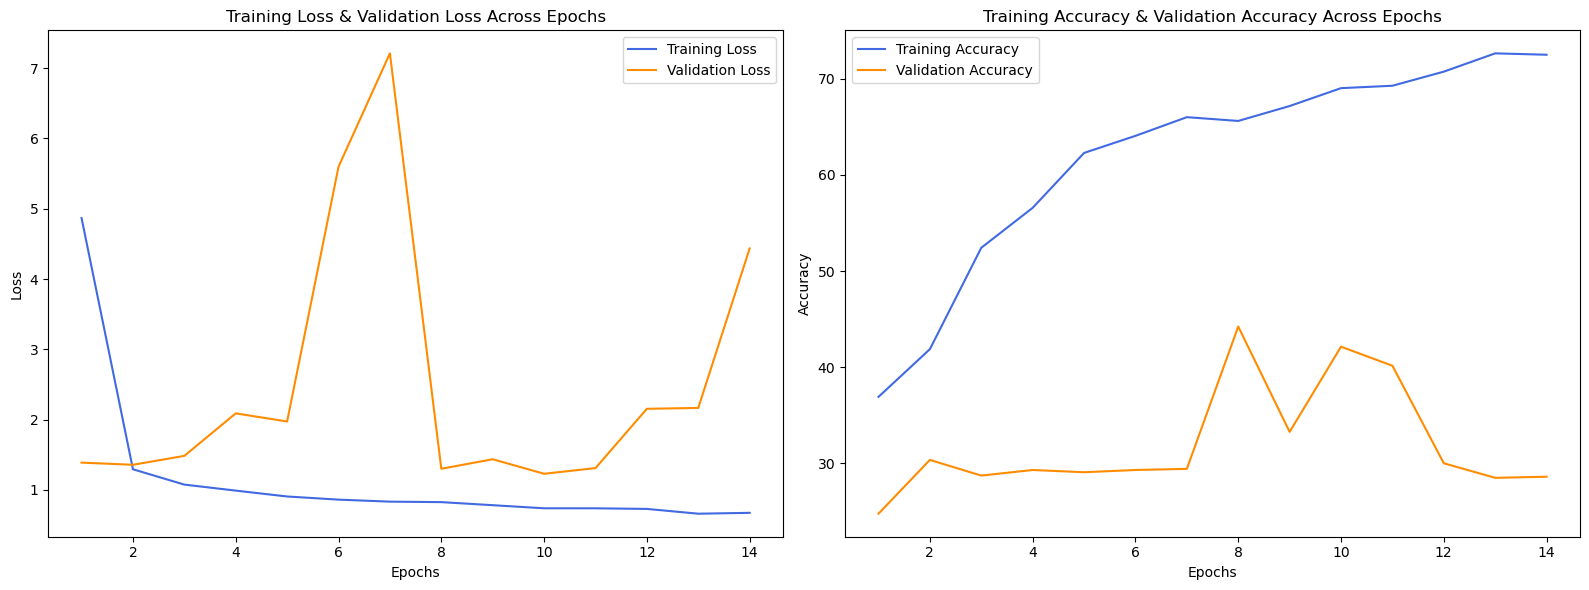

In [25]:
plot_train_valid_result(path_to_train_result_3)

In [26]:
model_3_eval_df

train_acc  train_loss  valid_acc  valid_loss  test_acc  \
model                                                                  
custom_cnn_3  69.039735    0.738554  42.123687    1.229822  42.86804   

              test_loss  
model                    
custom_cnn_3   1.249364

#### Model 3 Evaluation
- Model 3 is also constructed with the same strcuture as the baseline model, but includes an additional convolutional layer per block. It is to experiment whether adding additional convolutional layers, can help improving validaiton and test accuracy while producing a smoother validation curve.
- Despite aiming to improve regularization, model 3 shows the worst performance among all models so far, as it clearly underfits. 
- It is suspected that the model suffers from an architectural mismatch that prevents model from proper learning.

<br>

### Custom Model 4: Model 1 + Additional Dropout Layer Every Two Blocks

In [27]:
class CustomCNN_4(nn.Module):
    def __init__(self, fc_layer_size, dropout_rate, num_classes):
        super(CustomCNN_4, self).__init__()
        # define pool and activation func
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        
        # first convolutional block
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # second convolutional block
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        
        # third convolutional block
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)

        # fourth convolutional block
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(0.25)
        
        # fully connected layers
        self.fc1 = nn.Linear(50176, fc_layer_size)  
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_layer_size, num_classes)
        
    def forward(self, x):
        # first conv -> batch norm -> pool (224 -> 112) -> dropout (0.25)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))

        # second conv -> batch norm -> pool (112 -> 56) -> dropout (0.25)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)

        # third conv -> batch norm -> pool (56 -> 28) -> dropout (0.25)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        # fourth conv -> batch norm -> pool (28 -> 14) -> dropout (0.25)
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.dropout2(x)
        
        # flatten output 
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return x

In [28]:
# define custom_cnn_4 obj
custom_cnn_4 = CustomCNN_4(FC_LAYER_SIZE, DROPOUT_RATE, NUM_CLASSES)

# define path to save custom_cnn_4
path_to_custom_cnn_4 = f'{DIR_TO_SAVE_MODEL}/custom_cnn_4.pth'

# define path to save train result 
path_to_train_result_4 = f'{DIR_TO_TRAIN_RESULT}/train_result_custom_cnn_4.csv'

# define path to save best epoch
epoch_filename_4 = 'best_epoch_custom_cnn_4.csv'

# if haven't trained, train custom_cnn_4 model
if not os.path.exists(path_to_custom_cnn_4):
    # train model, save it to the given path, and return train result data
    result_df, epoch_custom_cnn_4 = train(custom_cnn_4, train_loader, valid_loader, DEVICE, LEARNING_RATE, EPOCHS, PATIENCE, path_to_custom_cnn_4)

    # save train result to the given path
    result_df.to_csv(path_to_train_result_4)

    # save best epoch 
    save_epoch_to_csv(epoch_custom_cnn_4, epoch_filename_4)

# get df that contains all train, valid, test acc and loss
model_4_eval_df = get_eval_df('custom_cnn_4', custom_cnn_4, epoch_filename_4, path_to_train_result_4, test_loader, path_to_custom_cnn_4, DEVICE)

<br>

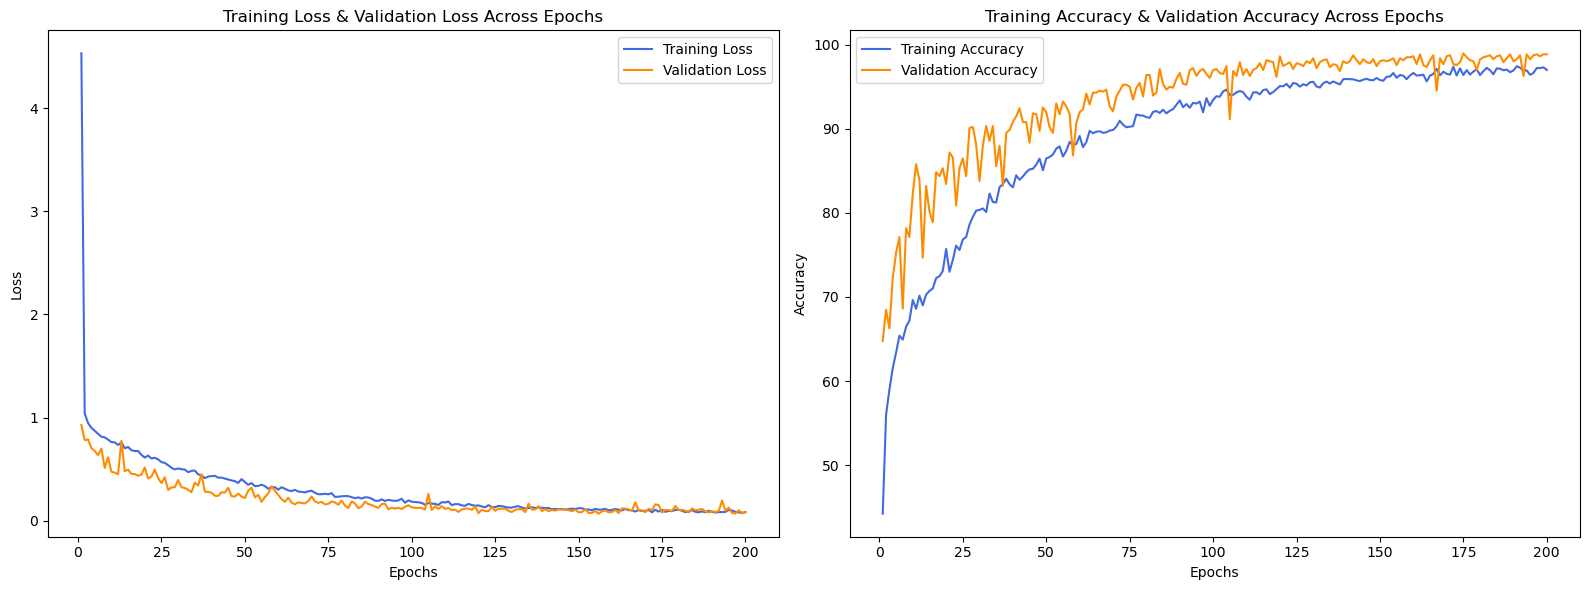

In [29]:
plot_train_valid_result(path_to_train_result_4)

In [30]:
model_4_eval_df

train_acc  train_loss  valid_acc  valid_loss   test_acc  \
model                                                                   
custom_cnn_4  97.288907    0.076148  98.833139    0.077027  99.008391   

              test_loss  
model                    
custom_cnn_4   0.032273

#### Model 4 Evaluation
- Model 4 is constructed with the same strcuture as the baseline model, but includes an additional dropout layer with a 25% dropout rate every two blocks.
- As mentioned earlier in model 2 evaluation, it is to experiment whether dropping dropout layers from model 2 would increase validation and test scores while maintaining good generalization.
- Model 4 presents the smoothest curve among all models so far, and it also has the highest validation and test scores.
- Therefore, adding an appropriate number of dropout layers does help improving model's generalization, which leads to better validation and test performance.
- Now, we have achieved a strong performing model, but we have only tried models with 4 convolutional blocks. Hence, it remains to be seen whether adding more convolutional blocks could surpass the performance of the current best performing model, model 4.

<br>

### Custom Model 5: Model 4 + Additional Convolutional Block

In [31]:
class CustomCNN_5(nn.Module):
    def __init__(self, fc_layer_size, dropout_rate, num_classes):
        super(CustomCNN_5, self).__init__()
        # define pool and activation func
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        
        # first convolutional block
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # second convolutional block
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        
        # third convolutional block
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)

        # fourth convolutional block
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(0.25)

        # fifth convolutional block
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # fully connected layers
        self.fc1 = nn.Linear(25088, fc_layer_size)  
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_layer_size, num_classes)
        
    def forward(self, x):
        # first conv -> batch norm -> pool (224 -> 112) 
        x = self.pool(self.relu(self.bn1(self.conv1(x))))

        # second conv -> batch norm -> pool (112 -> 56) -> dropout (0.25)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)

        # third conv -> batch norm -> pool (56 -> 28) 
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        # fourth conv -> batch norm -> pool (28 -> 14) -> dropout (0.25)
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.dropout2(x)

        # fifth conv -> batch norm -> pool (14 -> 7)
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        # flatten output 
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return x

In [32]:
# define custom_cnn_5 obj
custom_cnn_5 = CustomCNN_5(FC_LAYER_SIZE, DROPOUT_RATE, NUM_CLASSES)

# define path to save custom_cnn_5
path_to_custom_cnn_5 = f'{DIR_TO_SAVE_MODEL}/custom_cnn_5.pth'

# define path to save train result 
path_to_train_result_5 = f'{DIR_TO_TRAIN_RESULT}/train_result_custom_cnn_5.csv'

# define path to save best epoch
epoch_filename_5 = 'best_epoch_custom_cnn_5.csv'

# if haven't trained, train custom_cnn_5 model
if not os.path.exists(path_to_custom_cnn_5):
    # train model, save it to the given path, and return train result data
    result_df, epoch_custom_cnn_5 = train(custom_cnn_5, train_loader, valid_loader, DEVICE, LEARNING_RATE, EPOCHS, PATIENCE, path_to_custom_cnn_5)

    # save train result to the given path
    result_df.to_csv(path_to_train_result_5)

    # save best epoch 
    save_epoch_to_csv(epoch_custom_cnn_5, epoch_filename_5)

# get df that contains all train, valid, test acc and loss
model_5_eval_df = get_eval_df('custom_cnn_5', custom_cnn_5, epoch_filename_5, path_to_train_result_5, test_loader, path_to_custom_cnn_5, DEVICE)

<br>

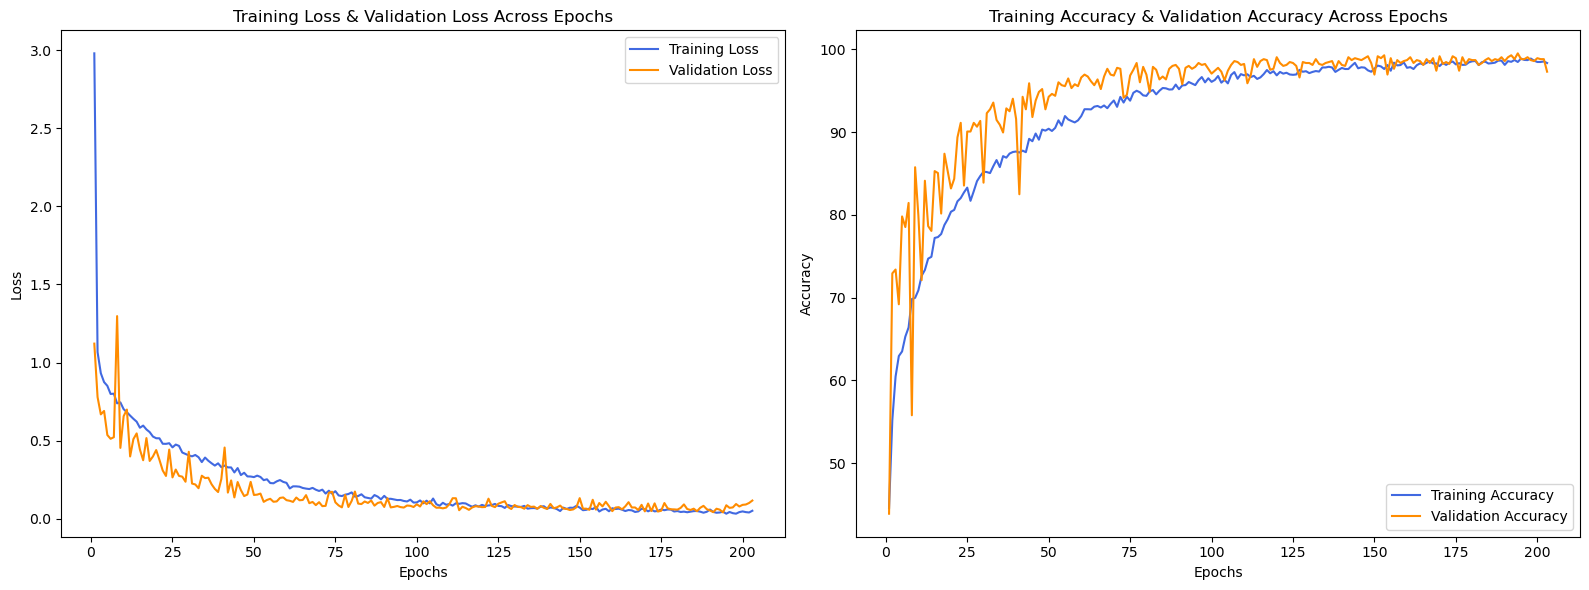

In [33]:
plot_train_valid_result(path_to_train_result_5)

In [34]:
model_5_eval_df

train_acc  train_loss  valid_acc  valid_loss   test_acc  \
model                                                                   
custom_cnn_5  98.654801    0.042728  98.599767     0.07873  98.932113   

              test_loss  
model                    
custom_cnn_5   0.063679

#### Model 5 Evaluation
- Model 5 is constructed with the same strcuture as model 4, but includes an additional convolutional block without a dropout layer.
- Although model 5 also has very high validation and test scores, model 4 still has the best validation and test results as well as the smoothest curve out of all five models.

<br>

## Model Comparison & Selection

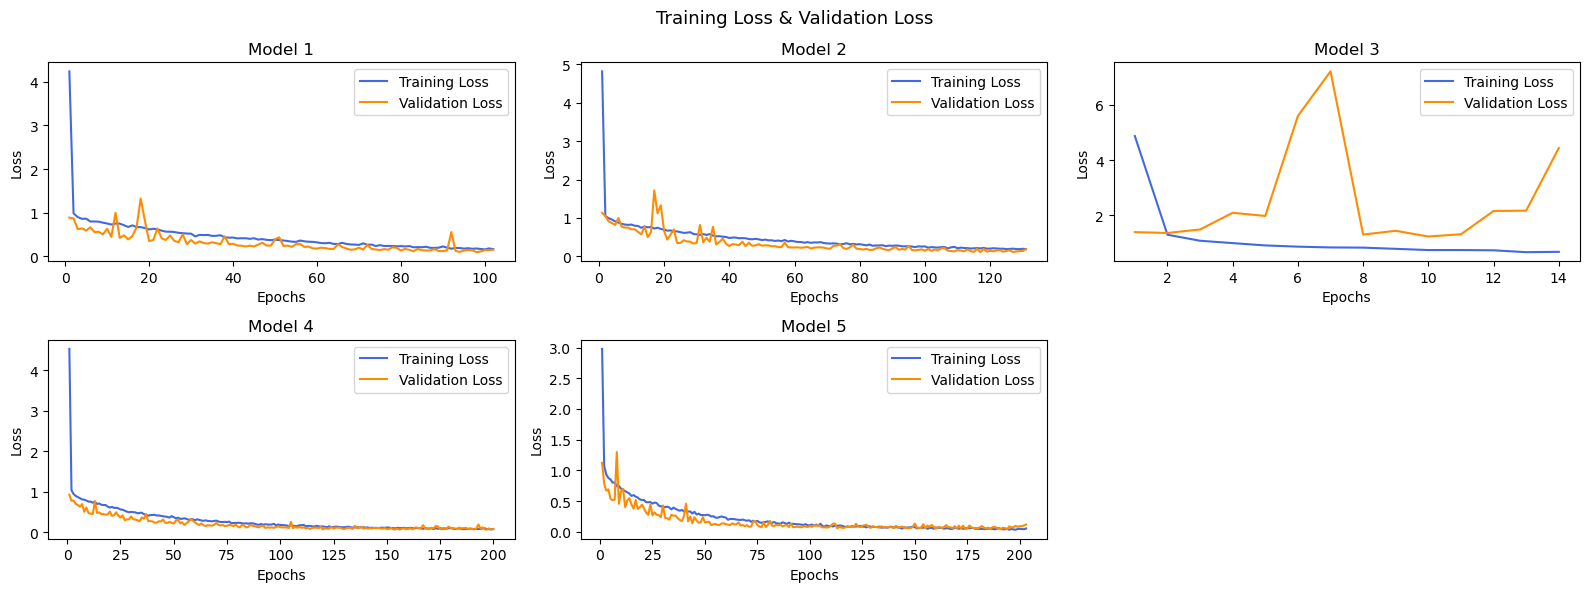

In [35]:
plot_all_loss_result(DIR_TO_TRAIN_RESULT)

<br>

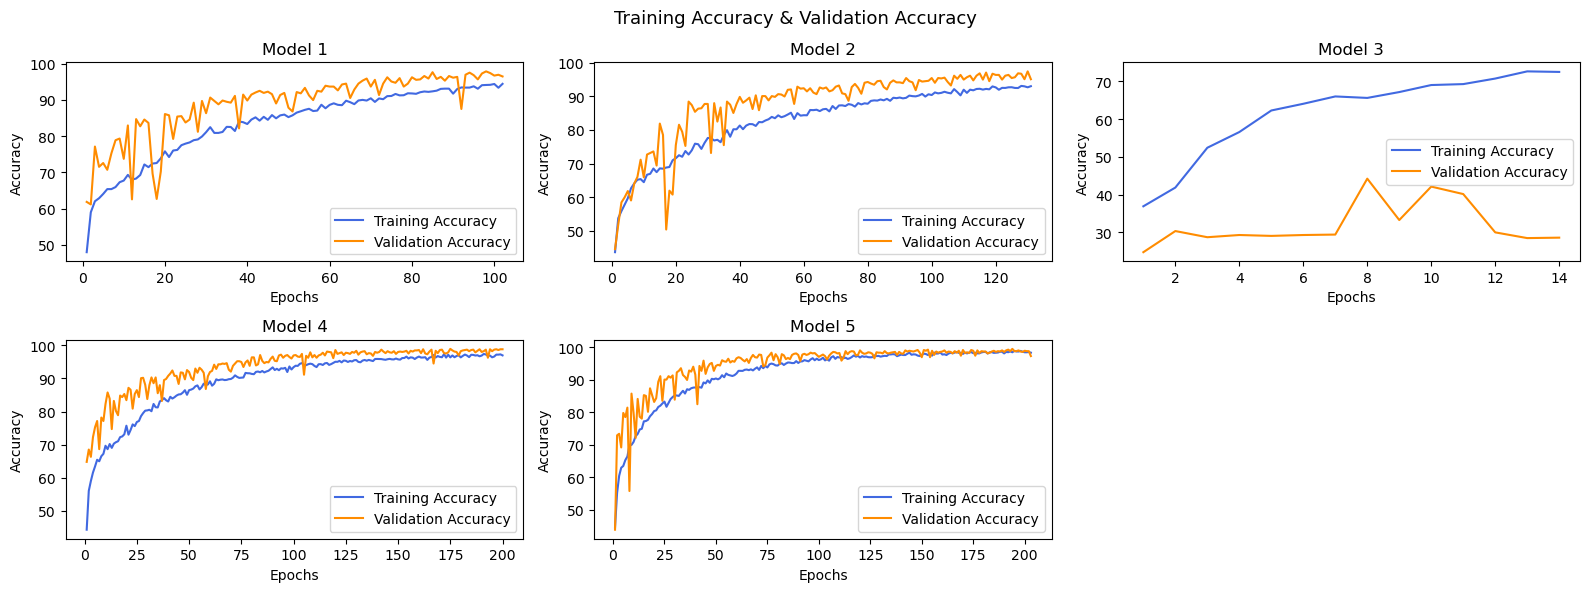

In [36]:
plot_all_acc_result(DIR_TO_TRAIN_RESULT)

<br>

In [37]:
all_models_eval_df = pd.concat([model_1_eval_df, model_2_eval_df, model_3_eval_df, model_4_eval_df, model_5_eval_df])

all_models_eval_df

train_acc  train_loss  valid_acc  valid_loss   test_acc  \
model                                                                   
custom_cnn_1  94.143212    0.178395  97.899650    0.094146  97.559115   
custom_cnn_2  92.487583    0.201564  96.849475    0.114395  95.804729   
custom_cnn_3  69.039735    0.738554  42.123687    1.229822  42.868040   
custom_cnn_4  97.288907    0.076148  98.833139    0.077027  99.008391   
custom_cnn_5  98.654801    0.042728  98.599767    0.078730  98.932113   

              test_loss  
model                    
custom_cnn_1   0.077345  
custom_cnn_2   0.102302  
custom_cnn_3   1.249364  
custom_cnn_4   0.032273  
custom_cnn_5   0.063679

In [38]:
print(f'Model with the highest validation accuracy: {all_models_eval_df['valid_acc'].idxmax()} | lowest validation loss: {all_models_eval_df['valid_loss'].idxmin()}')
print(f'Model with the highest test accuracy: {all_models_eval_df['test_acc'].idxmax()} | lowest test loss: {all_models_eval_df['test_loss'].idxmin()}')

Model with the highest validation accuracy: custom_cnn_4 | lowest validation loss: custom_cnn_4
Model with the highest test accuracy: custom_cnn_4 | lowest test loss: custom_cnn_4


- As illustrated above, model 4 demonsrates the strongest performance in validaiton and testing while presenting the smoothest validation curve across epochs.
- Therefore, model 4 is concluded to be the best model.

<br><br>

## Best Model Evaluation

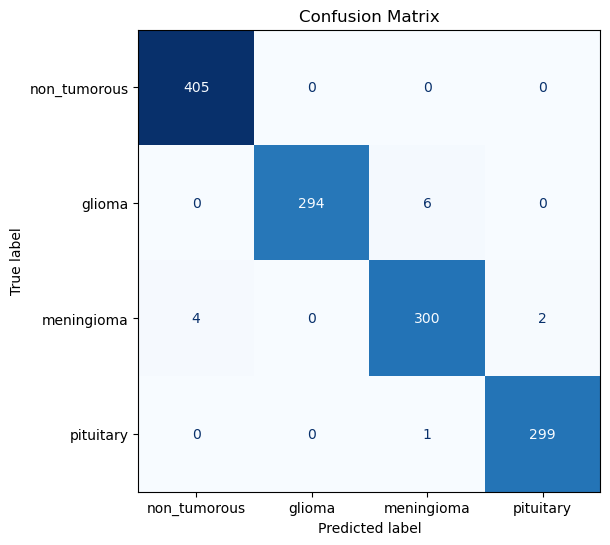

In [39]:
draw_conf_mat(test_loader, custom_cnn_4, path_to_custom_cnn_4, DEVICE, classes)

In [40]:
y_true, y_pred = get_labels(test_loader, custom_cnn_4, path_to_custom_cnn_4, DEVICE)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       405
           1       1.00      0.98      0.99       300
           2       0.98      0.98      0.98       306
           3       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



### Confusion Matrix & Classfication Report Interpretation
- Non-tumorous: the model correctly identifies all `non_tumorous` cases, with no misclassifications into tumorous categories.
- Glioma: the model identifies 294 out of 300 cases correctly and misclassifies 6 cases as meningioma.
- Meningioma: the model identifies 300 out of 306 cases correctly and misclassifies 2 cases as meningioma and 4 cases as non-tumorous.
- Pituitary: the model identifies 299 out of 300 cases correctly and misclassfies 1 case as meningioma.
- The final test accuracy, precision, recall, and f1-score is 99%, which demonstrates the strong performance of the model.

### Implications in a Cancer Detection Setting
- Misidentifying a non-tumorous case as a tumor leads to unnecessary diagnostic procedures and emotional distress and anxiety for the patience. Since the model can identify non-tumorous cases without any misprediction, this is a great achievement in this setting.
- The worst possible prediction is when the model misclassifies a tumor as non-tumorous, which may lead to severe, potentially fatal and life-threatning consequences. Hence, the most critical test error observed above is misclassfication of 4 meningioma tumors as non-tumorous.

<br>

### Saliency Map

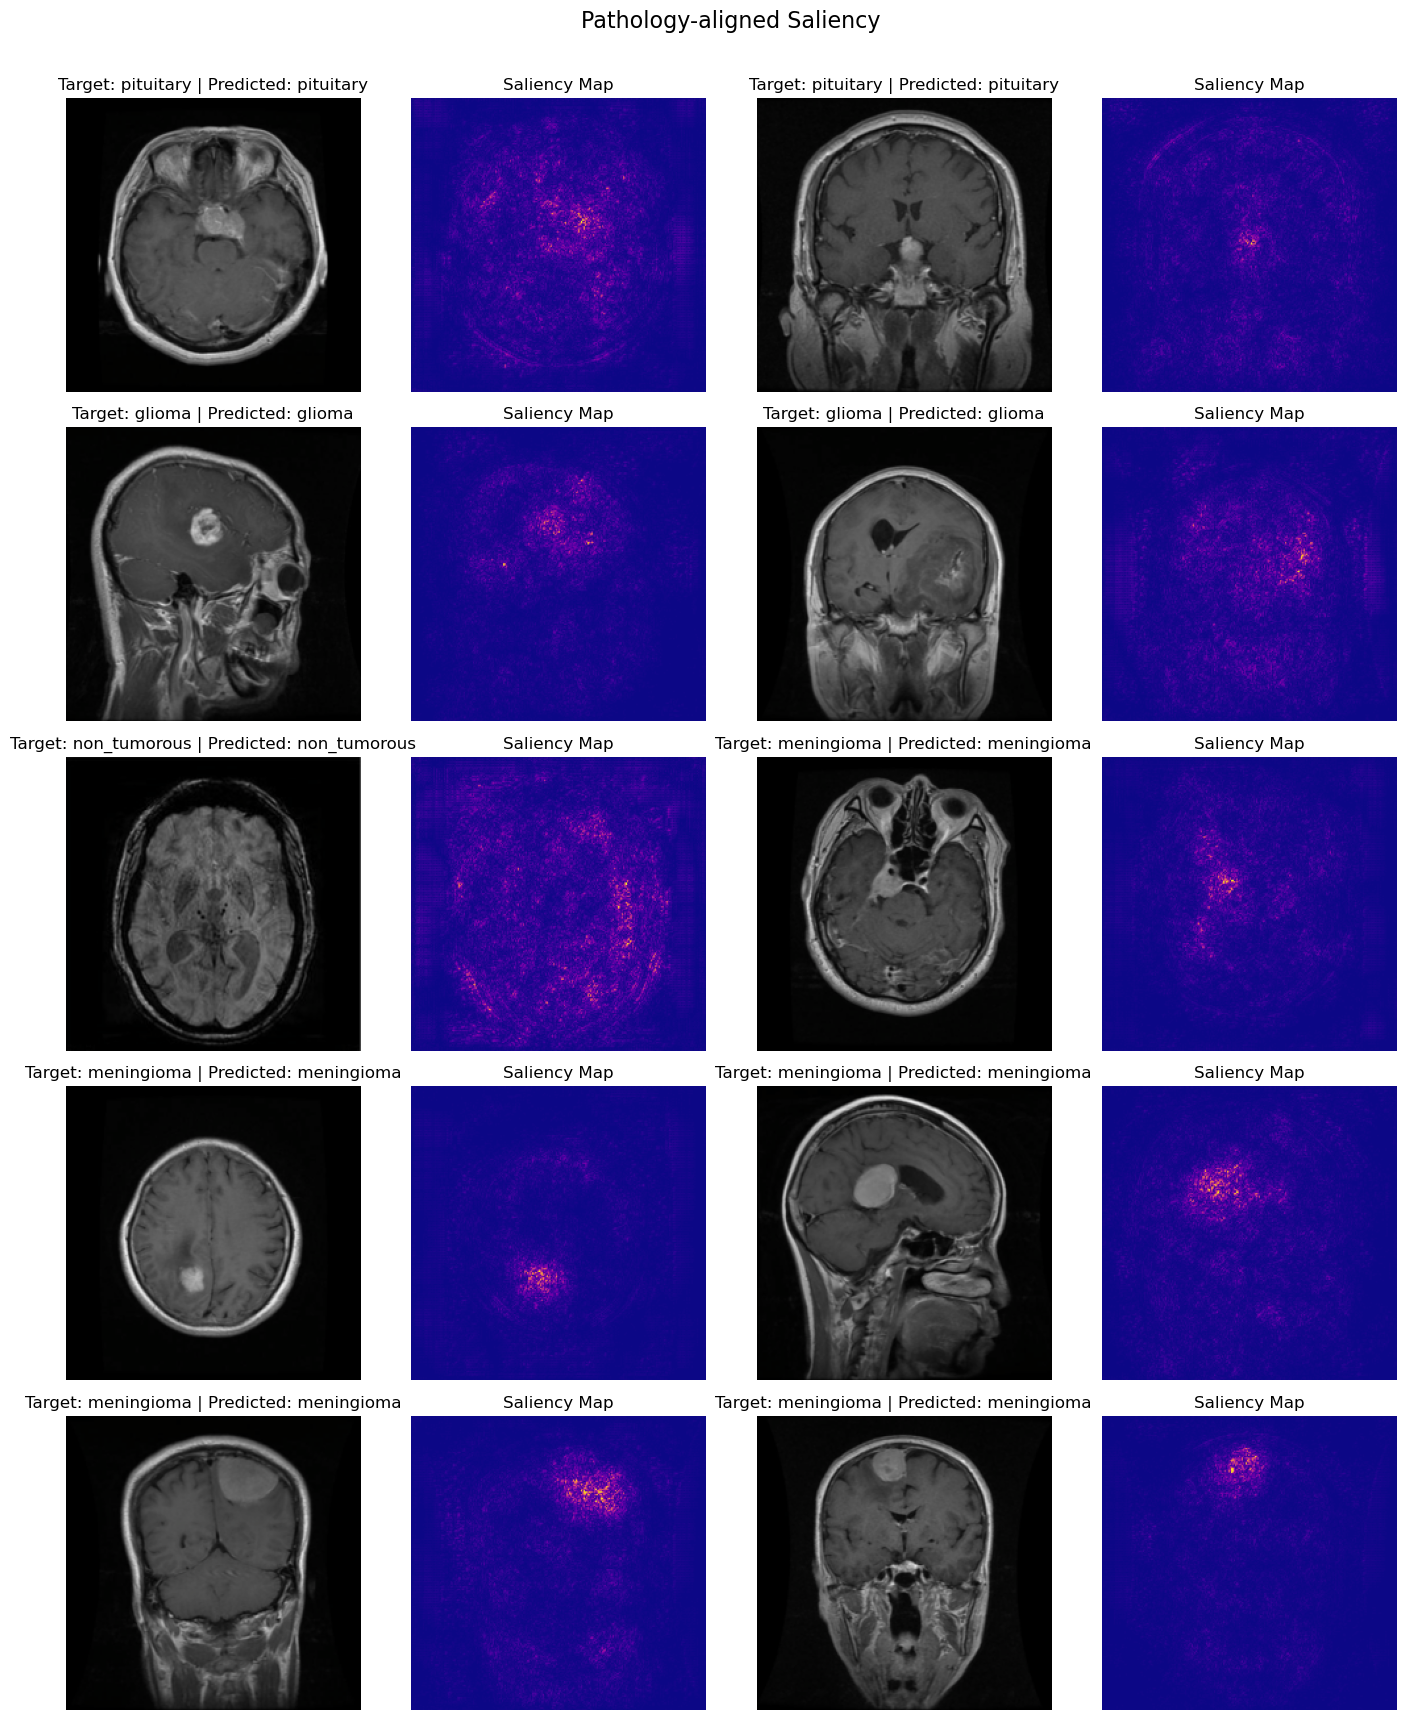

In [41]:
good_focus_indices = [149, 153, 384, 393, 917, 1043, 1061, 1163, 1184, 1223]
draw_saliency_map(custom_cnn_4, Dataset_test, good_focus_indices, classes, DEVICE, 'Pathology-aligned Saliency')

- The saliency maps above illustrate cases where the model correctly predicts the target labels and shows good attention on the tumor regions.

<br>

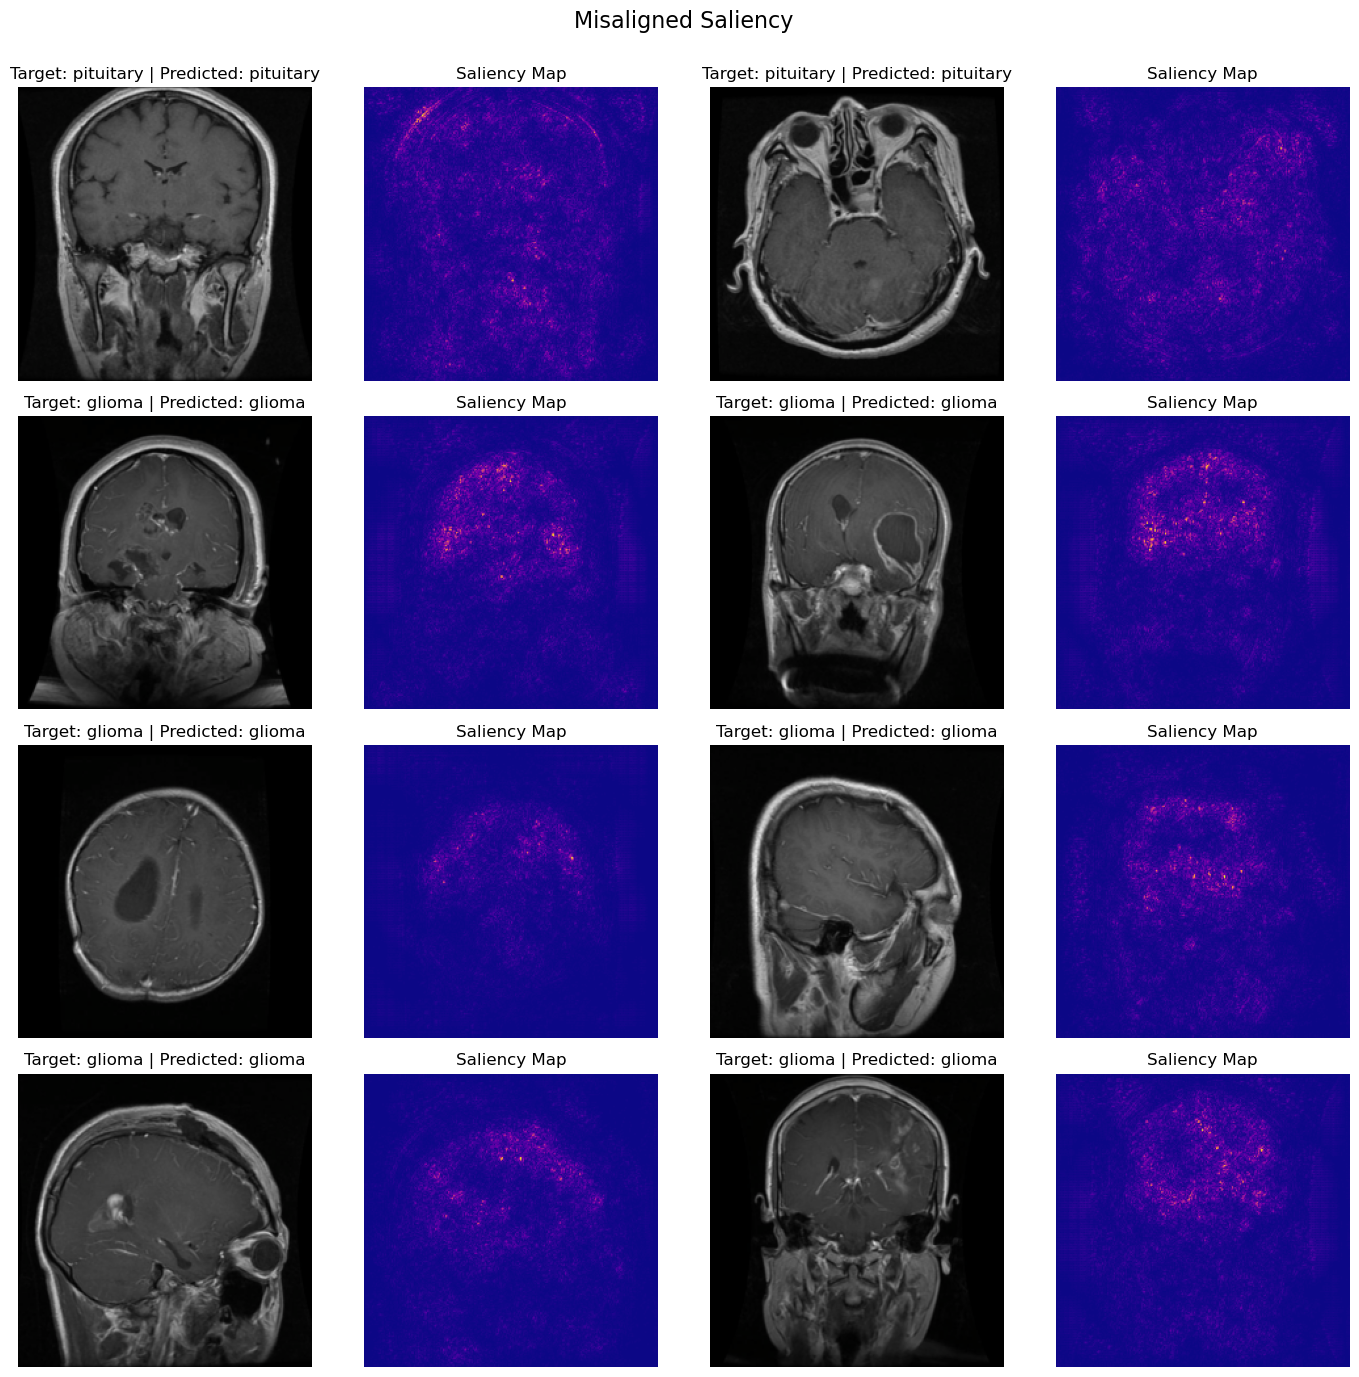

In [42]:
miss_focus_indices = [75, 211, 300, 338, 361, 396, 473, 559]
draw_saliency_map(custom_cnn_4, Dataset_test, miss_focus_indices, classes, DEVICE, 'Misaligned Saliency')

- The saliency maps above show examples that the model classifies tumor type correctly but its attention is misaligned with the tumor regions.
- These examples appear to have smaller and less evident tumor borders compared to the previous saliency map examples, which implies that the model might not work well on early-staged tumors.
- Since detecting cancer in its early stages significantly increases the cure rate, further investigation into model's decision-making process is needed to improve the success of early detection.

<br><br>

## Test on New Unseen Data
- Let's test the model on a completely new dataset to evaluate its robustness under dataset shift, which contains medical images scanned with different settings.

In [43]:
# retrieve images from each data folder
new_imgs = list(Path(NEW_DATA_DIR).glob('**/*.jpg')) 

new_img_paths = [str(img) for img in new_imgs 
                   if '.ipynb_checkpoints' not in str(img) and 'Copy' not in str(img)] # to not contain checkpoint files in img path list


# define a label for each image in both train and test set
new_labels = [os.path.split(os.path.split(name)[0])[1] for name in new_img_paths]
new_labels = [ordinal_encoding_mapping[label] for label in new_labels]
new_classes = list(set(new_labels))

# define dataset and dataloader
Dataset_new_data = Dataset(new_img_paths, new_labels, transform = test_transformer)
new_data_loader = DataLoader(Dataset_new_data, 
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             persistent_workers = True,   
                             prefetch_factor = PREFETCH_FACTOR,
                             drop_last = False, 
                             shuffle = False)

compute_acc(new_data_loader, 'New Data', True, custom_cnn_4, path_to_custom_cnn_4, DEVICE)

New Data Accuracy: 75.54% | New Data Loss: 1.375


- When tested with new data from a completely different dataset, the model returns 75.5% accuracy, indicating a huge drop from the original test accuracy of 99%.
- Since model accuracy is expected to decline under dataset shift with different settings, this accuracy is in fact a fairly good sign of robustness.
- However, because MRI images can be acquired under varying machine types and scanning settings, building a highly performative model for real-world use requires better generalization than the current model.

<br><br>

## Conclusion
- The model has an outstanding validation and test performance, acheiving 99% in all test metrics.
- However, it tends to have poorer performance in early-stage tumors such that further enhancement is necessary for more effective clinical use.
- Moreover, the current model is limited to classifying non-tumorous cases and 3 types of tumors such that it lacks the capability to identify all known brain tumor types.
- Therefore, for accurate detection of brain cancer, the model needs to be extended to address such limitaitons and support a broader range of brain tumor types for real-world deployment.